In [1]:
import numpy as np
from scipy import sparse
import sklearn

In [2]:
params = {}
params["lambda"] = 0.1
params["alpha"] = 0.1

params["gamma"] = 0.1*params["lambda"]


### Generating Dense Dataset

In [3]:
n = 10000;
p = 50000;
sparsity_level = 0.1;
block_size = 100


sparse_ = np.random.uniform(size=p) > sparsity_level
Beta_true = np.random.normal(size=(p))*sparse_
Beta_true = sparse.csc_matrix(Beta_true).T


X = np.random.random((n, p))
p_real = sum(sparse_)
print("Only ", p_real, "non zeros beta")
#X_real = np.random.random((n, p_real))
#X = sparse.csc_matrix((n, p))
#j = 0
#for j_real in range(p_real):
#    print(j_real)
#    while not sparse_[j]:
#    j+=1
#    X[:, j] = X_real[:, j_real:j_real+1]
#
print("X computed", X.shape, Beta_true.shape)


y = np.random.normal((X @ Beta_true), 0.01)
print("y computed")
A = 1/np.sqrt(n)*X
c = -1/n*X.T @ y

Only  44954 non zeros beta
X computed (10000, 50000) (50000, 1)


KeyboardInterrupt: 

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
plt.plot(X[:200, 0], y[:200], "r+");


## Optimization

In [ ]:
def penalty(z):
    return params["lambda"]*((1-params["alpha"])/2*np.linalg.norm(z, 1) + params["alpha"]*np.linalg.norm(z, 2))

In [ ]:
#print(c.shape)
def lagrangian(beta, xi, z, gamma=params["gamma"]):
    #print(beta.sign, beta.curvature)
    
    first = 1/2*np.linalg.norm(A @ beta, 2) 
    third = 1/2*gamma*np.linalg.norm(beta - z, 2) ## diminue si beta = z
    second = (c - xi).T @ beta ## diminue si beta augmente
    #print(first, second, third, fourth)
    #return first.squeeze() + second.squeeze() + third.squeeze() + fourth.squeeze() + penalty(z).squeeze()
    return first + second + third + penalty(z)


In [ ]:
def soft_thres(a, b):
    return -((np.abs(b) < a)*((a>0)*(a-b)+(a<=0)*(a+b)))

In [ ]:
def optimal_z(beta, xi, 
              alpha=params["alpha"], 
              lambd=params["lambda"], 
              gamma=params["gamma"]):
    return soft_thres(xi-gamma*beta, lambd*alpha)/((1-alpha)*lambd+gamma)

In [ ]:
B = A.T @ A + params["gamma"]*np.eye(p)

In [ ]:
## Algo



def one_cycle_racmbadmm(p, beta, xi, z):
    num_blocks = p // block_size
    # Split in blocks
    permutation = list(range(p))
    np.random.shuffle(permutation)
    
    # Optimize beta
    for i in range(num_blocks):
        indexes = permutation[(i*block_size):((i+1)*block_size)]
        remaining_indexes = [i for i in range(p) if i not in indexes]
        #print("indexes", indexes)
        B1 = B[np.ix_(indexes, indexes)]
        B2 = B[np.ix_(indexes, remaining_indexes)]

        # Closed form optimum
        betasub_opt = - np.linalg.inv(B1)@(B2 @ beta[remaining_indexes] + (c-xi-params["gamma"]*z)[indexes])
        
        beta[indexes] = betasub_opt

    # Optimal 
    z[indexes] = optimal_z(beta[indexes], xi[indexes])
    # Optimize xi
    xi = xi - params["gamma"]*(beta - z)
    
    return beta, xi, z

In [ ]:
#lagrangian(Beta_true, 0, Beta_true)

In [ ]:
beta0 = np.zeros((p, 1))
z0 = np.zeros((p, 1))
xi0 = np.zeros((p, 1))

In [ ]:
lag = []
beta_error = []
for k in range(10): 
    beta0, xi0, z0 = one_cycle_racmbadmm(p, beta0, xi0, z0)
    beta_error.append(np.linalg.norm(Beta_true - beta0, 2))
    lag.append(lagrangian(beta0, xi0, z0))
    #print()

In [ ]:
plt.plot(beta_error)
plt.yscale("log")
#plt.xscale("log")

## Scikit learn



In [ ]:
from sklearn.linear_model import ElasticNet
sklearn_model = ElasticNet(alpha=params["lambda"], l1_ratio=params["alpha"])

In [ ]:
reg_ = sklearn_model.fit(X, y)

In [ ]:
reg_.coef_.shape
Beta_true[:, 0]

In [ ]:
np.linalg.norm(reg_.coef_ -Beta_true.todense()[:, 0])

In [ ]:
reg_.coef_;

In [ ]:
if p == 1:
    plt.plot(X[:, 0], X[:, 0:1]*Beta_true, label="True data")
    plt.plot(X[:, 0], X[:, 0] * reg_.coef_, label="Regression")
    plt.legend()

# SVM

In [5]:
## Load datasets
from sklearn.datasets import load_iris
data = load_iris()

In [70]:
X = data.data
y = data.target
n = X.shape[0]

# Set up Q
import numpy as np
import scipy.ndimage.filters as fi

def GaussianMatrix(X,sigma=10):
    row,col=X.shape
    GassMatrix=np.zeros(shape=(row,row))
    X=np.asarray(X)
    i=0
    for v_i in X:
        j=0
        for v_j in X:
            GassMatrix[i,j]=Gaussian(v_i.T,v_j.T,sigma)
            j+=1
        i+=1
    return GassMatrix
def Gaussian(x,z,sigma):
    return np.exp((-(np.linalg.norm(x-z)**2))/(2*sigma**2))

Q = GaussianMatrix(X)

In [101]:
import cvxpy as cp
def solve_sub_problem_a2(alpha_1, alpha_2, xi, zeta, c, gamma=params["gamma"]):
    # Solve for alpha_2
    alpha_2 = cp.Variable(n)
    def lag_alpha_2(alpha_2):
        return zeta.T @ alpha_2 + gamma/2*cp.norm(alpha_1 - alpha_2)**2
    problem = cp.Problem(cp.Minimize(lag_alpha_2(alpha_2)), [alpha_2 >= np.zeros(n), alpha_2 <= c*np.ones(n)])
    problem.solve()
                         
    # Print result.
    print(problem.status)
    print("\nThe optimal value is", problem.value)
    return alpha_2.value

In [124]:
def to_minimize(alpha_1):
    return 0.5*alpha_1.T @ Q @ alpha_1 - sum(alpha_1)

In [148]:
B = Q + params["gamma"]*(y @ y.T + np.eye(n))
ones = np.ones(n)
block_size=15
def one_cycle_rac_mbadmm_svm(alpha_1, alpha_2, xi, zeta, c, gamma=params["gamma"]):
    num_blocks = n // 15
    # Split in blocks
    permutation = list(range(n))
    np.random.shuffle(permutation)
    print(to_minimize(alpha_1))
    for i in range(num_blocks):
        indexes = permutation[(i*block_size):((i+1)*block_size)]
        #print(indexes)
        remaining_indexes = [i for i in range(n) if i not in indexes]
        B1 = B[np.ix_(indexes, indexes)]
        B2 = B[np.ix_(indexes, remaining_indexes)]
        
        #print(block_size, B1.shape, B2.shape, beta[remaining_indexes].shape)
        #import pdb; pdb.set_trace()
        alpha_1_sub_opt = np.linalg.inv(B1)@(-B2 @ alpha_1[remaining_indexes] + 
                                             (ones+xi*y+zeta+params["gamma"]*alpha_2)[indexes])
        print(alpha_1_sub_opt)
        alpha_1[indexes] = alpha_1_sub_opt
        print(to_minimize(alpha_1))
        print(np.all(alpha_1>=0), np.all(alpha_1<=c))
    
    alpha_2 = solve_sub_problem_a2(alpha_1, alpha_2, xi, zeta, c)
    print(alpha_2)
    # Optimize xi
    xi = xi - params["gamma"]*(y.T @ alpha_1)
    # Optimize zeta 
    zeta = zeta - params["gamma"]*(alpha_1 - alpha_2)
    print()
    return to_minimize(alpha_1), alpha_1, alpha_2, xi, zeta
    

In [149]:
alpha_1 = np.zeros(n)
alpha_2 = alpha_1.copy()
xi = 0
zeta = alpha_1.copy()

In [150]:
n

150

In [151]:
losses = []
for i in range(10):
    loss, alpha_1, alpha_2, xi, zeta  = one_cycle_rac_mbadmm_svm(alpha_1, alpha_2, xi, zeta, 1)
    losses.append(loss)

0.0
[ 0.19188545  0.15741883  0.10719194 -0.15780228  0.20737692  0.14514319
 -0.14482229 -0.11412125  0.30361448  0.09836075  0.0472344   0.03196887
 -0.3561721  -0.28849472  0.06760004]
-0.26057326890284016
False True
[ 0.04999467 -0.03404444  0.27151699 -0.21066707  0.04373507 -0.08413267
  0.1534168   0.04682523 -0.11197755  0.00121871  0.25620795 -0.07674697
  0.1432572  -0.10650772 -0.33269442]
-0.2731138167795012
False True
[ 0.09252307 -0.12443614  0.00578046 -0.002117    0.03983451 -0.05166582
 -0.07450509 -0.03865566 -0.18501964  0.04866241 -0.01482007  0.03358228
  0.08923814  0.03790992  0.14657006]
-0.27653980670314665
False True
[ 0.0907057  -0.09558573  0.04132269 -0.01359924  0.05628714  0.02255106
 -0.13950755  0.02337365 -0.02588045  0.12650213 -0.05014839 -0.10826425
 -0.00461139 -0.01483125  0.09733207]
-0.28232947667648234
False True
[-0.01214433  0.02573931 -0.06532113  0.00595521  0.01803002 -0.00333149
  0.01548845  0.05869283 -0.02779999  0.02006675 -0.0451449 

optimal_inaccurate

The optimal value is 275.4567473162934
[9.90263722e-01 3.04686404e-03 9.89905486e-01 4.26170332e-03
 9.91035700e-01 9.20673786e-01 2.01580848e-03 9.94240074e-01
 3.73253760e-03 7.35249496e-03 9.96908291e-01 7.88122220e-03
 4.13962552e-03 8.99239092e-03 9.96445138e-01 9.87523691e-03
 1.78544327e-02 1.52998226e-02 9.97976407e-01 4.77718598e-03
 9.93424991e-01 9.96776216e-01 4.59882522e-03 1.23274914e-03
 3.64034695e-03 2.62797822e-03 1.79901237e-03 9.98305129e-01
 9.97275290e-01 4.74131730e-03 5.30208669e-03 1.06833121e-02
 9.96117885e-01 9.95903591e-01 3.20713213e-02 4.41872539e-03
 9.98848391e-01 9.97824431e-01 9.83967513e-01 9.94493623e-01
 9.82202490e-01 7.67651776e-03 2.06228450e-02 1.33166248e-03
 3.98700342e-03 3.81001723e-03 9.95793036e-01 5.34667584e-03
 9.94600364e-01 9.90391393e-01 2.53374818e-03 1.05714960e-03
 2.01476211e-03 9.96279561e-01 9.39259610e-04 9.77921367e-04
 8.58501443e-04 4.88339859e-03 3.04441500e-03 1.75635471e-03
 9.85928566e-01 8.87787273

TypeError: unsupported operand type(s) for -: 'float' and 'NoneType'

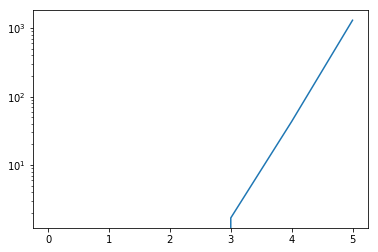

In [152]:
import matplotlib.pyplot as plt
plt.plot(losses)
plt.yscale('log')
plt.show()